#Library and Dependencies

In [9]:
import zipfile,os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.saved_model import save

In [10]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Data Preparation

In [11]:
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [18]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [19]:
#https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
!kaggle datasets download -d muratkokludataset/rice-image-dataset

 99% 217M/219M [00:01<00:00, 202MB/s]
100% 219M/219M [00:01<00:00, 189MB/s]


In [20]:
!unzip \rice-image-dataset.zip && rm *.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Kar

In [21]:
rice_dir = './Rice_Image_Dataset'

In [22]:
!rm ./Rice_Image_Dataset/*.txt

#Explore Data

In [25]:
classes = os.listdir(rice_dir)
num_classes = len(classes)
print("Jumlah kategori:", num_classes)
print("=============================")
for i, cls in enumerate(classes):
  print(f"{i+1}. {cls}")

Jumlah kategori: 5
1. Arborio
2. Basmati
3. Ipsala
4. Jasmine
5. Karacadag


In [26]:
total_data = 0
for cls in classes:
  temp = os.path.join(rice_dir,cls)
  num = len(os.listdir(temp))
  print("Data {0}: {1}".format(cls,num))
  total_data += num
print("======================")
print("Total data:",total_data)

Data Arborio: 15000
Data Basmati: 15000
Data Ipsala: 15000
Data Jasmine: 15000
Data Karacadag: 15000
Total data: 75000


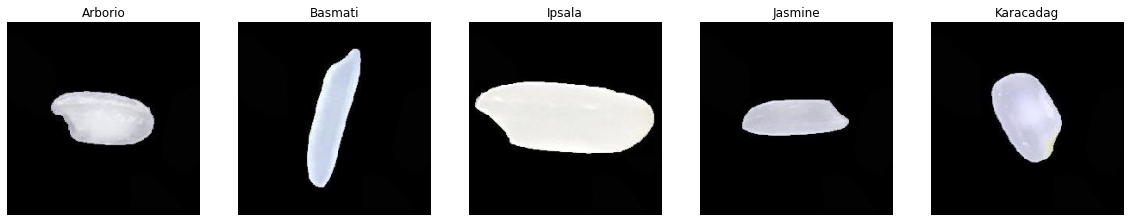

In [30]:
%matplotlib inline

nrows = 1
ncols = 5

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

for i, cls in enumerate(classes):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')

  path = os.path.join(rice_dir,cls)
  file_name = os.listdir(path)[0]
  img = image.load_img(os.path.join(path,file_name), target_size=(224,224))
  plt.title(cls)
  plt.imshow(img)

plt.show()

#Data Preprocessing

In [31]:
datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.2)

In [32]:
train_generator = datagen.flow_from_directory(
    rice_dir,
    target_size=(300,300),
    batch_size = 32,
    class_mode = "categorical",
    shuffle=True,
    subset='training'
)

val_generator = datagen.flow_from_directory(
    rice_dir,
    target_size=(300,300),
    batch_size = 32,
    class_mode = "categorical",
    shuffle=True,
    subset='validation'
)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


#Modeling

In [40]:
model = Sequential([
    Conv2D(4, (3,3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2),
    Conv2D(8, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.25),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 298, 298, 4)       112       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 149, 149, 4)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 147, 147, 8)       296       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 73, 73, 8)        0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 16)        1168      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 35, 35, 16)      

In [41]:
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss="categorical_crossentropy", 
    metrics = ["accuracy", Precision(), Recall()])

In [35]:
callbacks=[
    EarlyStopping(
        monitor='val_loss',
        patience=3, 
        restore_best_weights=True
    ), 
    ReduceLROnPlateau(
        monitor='val_loss',
        patience=1
    )
]

In [42]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs=20,
    verbose = 1,
    callbacks = callbacks)

Epoch 1/20
1875/1875 [==============================] - 279s 148ms/step - loss: 0.1403 - accuracy: 0.9527 - precision_2: 0.9563 - recall_2: 0.9498 - val_loss: 0.0796 - val_accuracy: 0.9726 - val_precision_2: 0.9729 - val_recall_2: 0.9725 - lr: 0.0010
Epoch 2/20
1875/1875 [==============================] - 267s 143ms/step - loss: 0.0918 - accuracy: 0.9697 - precision_2: 0.9700 - recall_2: 0.9694 - val_loss: 0.0739 - val_accuracy: 0.9733 - val_precision_2: 0.9734 - val_recall_2: 0.9733 - lr: 0.0010
Epoch 3/20
1875/1875 [==============================] - 264s 141ms/step - loss: 0.0746 - accuracy: 0.9758 - precision_2: 0.9760 - recall_2: 0.9757 - val_loss: 0.1168 - val_accuracy: 0.9619 - val_precision_2: 0.9620 - val_recall_2: 0.9619 - lr: 0.0010
Epoch 4/20
1875/1875 [==============================] - 264s 141ms/step - loss: 0.0350 - accuracy: 0.9884 - precision_2: 0.9885 - recall_2: 0.9884 - val_loss: 0.0213 - val_accuracy: 0.9935 - val_precision_2: 0.9937 - val_recall_2: 0.9935 - lr: 1.0

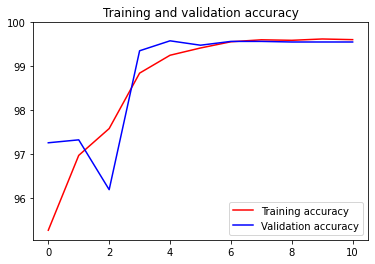

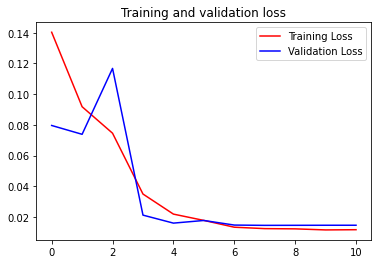

In [43]:
%matplotlib inline
acc = [x*100 for x in history.history['accuracy']]
val_acc = [x*100 for x in history.history['val_accuracy']]
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.ylim(top=100)
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#Mengubah Model

In [44]:
export_dir = '/content/saved_model/'
save(model, export_dir)

In [45]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [47]:
tflite_model_file = pathlib.Path('/content/rices.tflite')
tflite_model_file.write_bytes(tflite_model)

40683660